# HPC Mini-Challenge 2 - Beschleunigung in Data Science
#### FHNW - FS2022

Original von S. Suter, angepasst für das HS22 von S. Marcin

### Ressourcen
* HPC mit Python – days 1-2 ([Videos](https://www.youtube.com/playlist?list=PL1tk5lGm7zvSC4rLm5Y71372R1Yxl2Dg_), [Github](https://github.com/eth-cscs/PythonHPC)), 2020:
    - JupyterLab Tutorial (z.B. GPU Ressourcen)
    - Introduction
    - Vectorization
    - Profiling
    - JIT Numba CPU 1 + 2
    - Siehe auch aktuelles Tutorial von 2021

Abgabe von: <font color='blue'>Simon Luder</font>


## Ausgangslage/Problemstellung


Das menschliche Gehirn verliert mit zunehmendem Alter an Funktion. Ein Teil davon ist "gesundes Altern", d.h. es passiert bei jedem Menschen. Ein relativ großer Prozentsatz der alternden Bevölkerung erlebt jedoch auch einen kognitiven Rückgang, der extremer ist als bei anderen. Eine mildere Version davon wird als 'leichte kognitive Beeinträchtigung' (MCI) bezeichnet, bei der die Person grösstenteils noch funktionieren kann. Bei einem Teil der MCI-Patienten schreitet die Krankheit fort und führt zu Demenz bzw. Alzheimer. In diesem Projekt liegen uns MRI-Bilder des Gehirns von Alzheimerpatienten vor. Im spezifischen analysieren wir die Entwicklung von Alzheimer-Patienten anhand von MRI-Bildern, welche über eine bestimmte Zeit zur Verfügung stehen. Es stellt sich die Frage, wie gut sich die Veränderungen des Krankheitsbildes mittels Korrelationen über die Bildanalyse zeigen lassen. Zur Analyse sind Gigabytes von Daten in Form von 3D Gehirn-Scans vorhanden. Die Verarbeitung dieser grossen Datenmengen kann von Komprimierung profitieren.

Das Verständnis von Gedächtnis- und Kognitionsstörungen und die Möglichkeit, den Gesundheitszustand des Gehirns zu erkennen, vorherzusagen und zu überwachen, ist ein gesellschaftlich und wirtschaftlich relevantes Thema der angewandten Wissenschaft. Alle neuen Erkenntnisse, die datenwissenschaftliche Methoden liefern können, werden zur Entwicklung von Lösungen beitragen, mit denen die Gesundheit des Gehirns erkannt, vorhergesagt und überwacht werden kann.

### Daten
[ADNI (Alzheimer's Disease Neuroimaging Initiative)](https://adni.loni.usc.edu/) ist ein internationales Projekt zur Erfassung von Daten über die Alzheimer-Krankheit und andere verwandte Gehirnerkrankungen, die zu einem kognitiven Abbau führen. Die Initiative wurde mit grossem Enthusiasmus aufgenommen, und viele Mitarbeiter aus der ganzen Welt haben Daten zur Verfügung gestellt, die sie in ihren eigenen Forschungsteams gesammelt haben. Die ADNI-Initiative ist ein öffentliches (gemeinnütziges) Projekt, da viele Forschungseinrichtungen auf der ganzen Welt mit Steuergeldern dazu beigetragen haben. Das bedeutet zwei Dinge: 1) Die Daten stehen uns für Forschungs- und Bildungszwecke zur Verfügung, 2) wir dürfen die Daten nicht an andere weitergeben oder kommerzialisieren.



***Wichtig!*** Die Studierenden dürfen die Daten nur für Forschungszwecke verwenden und erhalten nur einen Beispielsdatensatz. Die ADNI-Daten dürfen nur lokal auf dem Computer oder auf FHNW-Ressourcen wie dem GitLab-Repository, d.h. nicht auf Github, gespeichert werden. Siehe [ADNI Datennutzungsvereinbarung](https://adni.loni.usc.edu/wp-content/uploads/how_to_apply/ADNI_Data_Use_Agreement.pdf).


<img src="images/mri-example.png" alt="MRI example image (coronal slice)" width="150"/> <img src="images/slicing.png" alt="Slicing" width="400"/>

Links: MRI Beispielbild (coronaler Schnitt), rechts: MRI slicing

## Zielsetzung

In dieser Aufgabe sollen die Parallelisierung und Beschleunigung unterschiedlicher Methoden von Bildrekonstruktion basierend auf komprimierten (zerlegten) Daten implementiert, analyisiert und diskutiert werden. Die Rekonstruktion der Daten aus der komprimierten Version soll dabei möglichst in Echtzeit geschehen. 

## Lösungsweg / Vorgehen

Wir lösen diese Aufgabenstellung indem wir die Singulärwertzerlegung (SVD: singular value decomposition) als Kompressionsmethode verwenden (Matrixfaktorisierung). Siehe Abbildungen unten. Um die Rekonstruktion der Daten aus der SVD-Matrixfaktoriseriung möglichst in Echtzeit zu bewerkstelligen, evaluieren wir dafür verschiedene Methoden der Parallelisierung und Beschleunigung in Python. 
* Beschleunigungsvarianten auf der CPU:
    - Numpy Operationen inkl. Broadcasting
    - Numba
    - Threads
* Beschleunigung auf der GPU:
    - Cupy (analog zu Numpy)
    - Numba (analog zu Numba)

<img src="images/svd_reco.png" alt="svd vis" width="500"/> <img src="images/svd.png" alt="svd" width="500"/>

## Daten Zerlegen
### 1.1 Daten laden


In [1]:
import os
import imageio
import numpy as np
import matplotlib.pyplot as plt

subfolder = '001'
folders = os.path.join('adni_png', subfolder)
n = 3


images = np.empty([n,256,170])
idx = 0
names = []
for filename in os.listdir(folders):
    if filename.endswith('.png') and '145' in filename:
        with open(os.path.join(folders, filename), 'r') as f:
            im = imageio.imread(f.name)
            names.insert(idx,f.name[-17:-4])
            images[idx,:,:] = im
            print (names[idx], im.shape)
            idx += 1
            if idx >=n:
                break
            
print(images.shape)

m1-1_slice145 (256, 170)
m1-2_slice145 (256, 170)
m3-1_slice145 (256, 170)
(3, 256, 170)


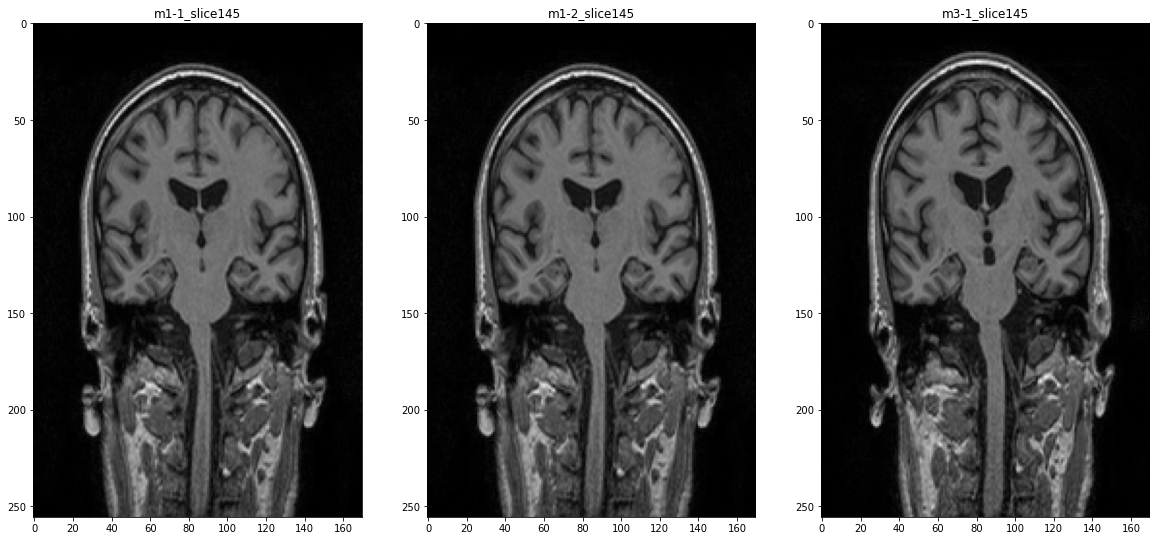

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,10))

for a in range(images.shape[0]):
    ax = fig.add_subplot(1,images.shape[0],a+1)
    ax.imshow(images[a],cmap='gray')
    ax.set_title(names[a])


### 1.2 Daten zerlegen

In [3]:
im = images[0]
im = im -im.min() / im.max() - im.min() # normalize data 
u,s,vt = np.linalg.svd(im, full_matrices=False)

In [4]:
def reconstruct_svd(u,s,vt,k):
    """SVD reconstruction for k components using np.dot()
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    reco = np.dot(u[...,:k], np.dot(np.diag(s[:k]), vt[:k,...]))
        
    return reco

In [5]:
from skimage import metrics

# calculate various metrics for the reconstruction quality
def calculate_metrics(im, reco):
    mse = metrics.mean_squared_error(im, reco)
    ssim_score = metrics.structural_similarity(im, reco)
    hdist = metrics.hausdorff_distance(im, reco)
    return f"MSE: {mse:.2f}, SSIM {ssim_score:.2f}, HDIST: {hdist:.2f}"

original size:  43520
decomposed to n =  170 , size:  72590
decomposed to n =  130 , size:  55510
decomposed to n =  90 , size:  38430
decomposed to n =  50 , size:  21350
decomposed to n =  10 , size:  4270


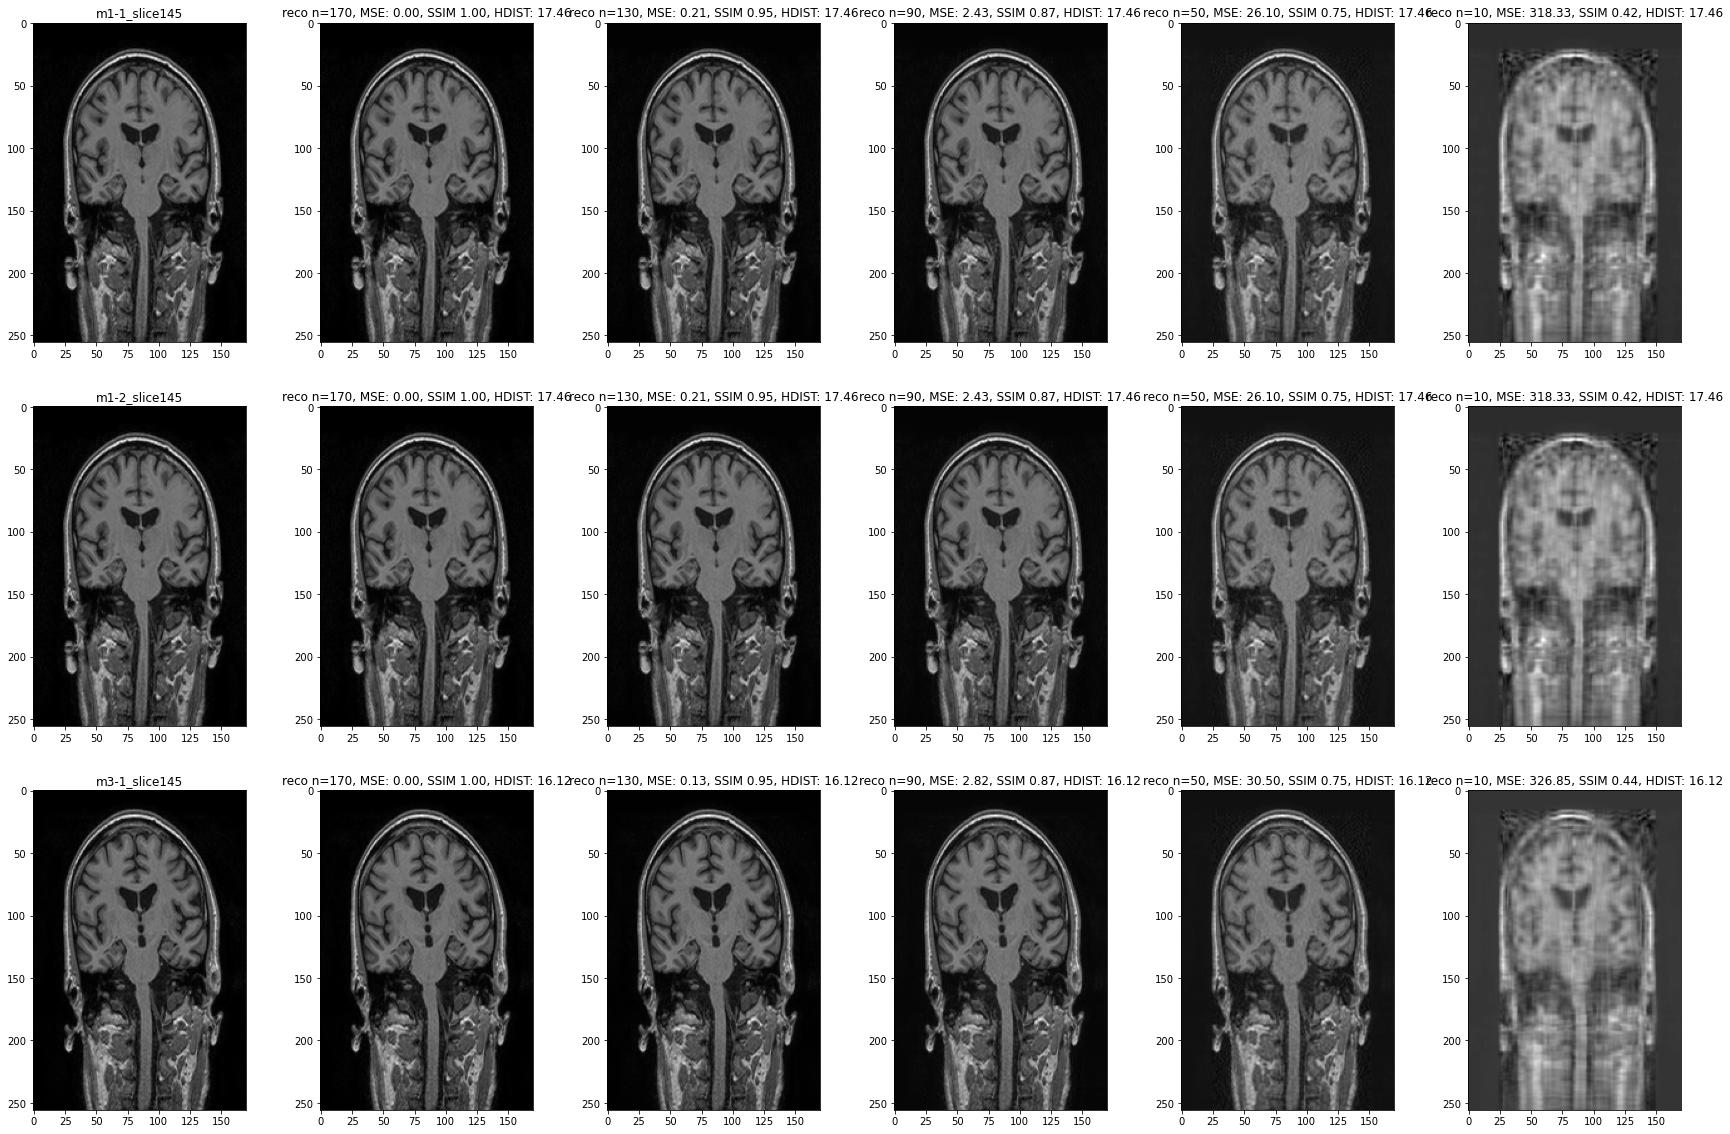

In [6]:
fig, axs = plt.subplots(images.shape[0], 6, figsize=(30,20))

for a in range(images.shape[0]):
    im = images[a]
    im = im -im.min() / im.max() - im.min()    
    u,s,vt = np.linalg.svd(im, full_matrices=False)

    axs[a, 0].imshow(im,cmap='gray')
    axs[a, 0].set_title(names[a])
    
    if (a == 0):
        print('original size: ', im.shape[0]*im.shape[1])
    
    for idx, n in enumerate(range(s.shape[0], 0, -40)):
        reco = reconstruct_svd(u,s,vt,n)
        if (a == 0):
            print('decomposed to n = ', n , ', size: ', u.shape[0] * n + n + vt.shape[0]*n)
    
        axs[a, idx+1].imshow(reco,cmap='gray')
        axs[a, idx+1].set_title('reco n=' + str(n) + ', ' + calculate_metrics(im, reco))

### 2 Rekonstruktionsvarianten
Siehe Bilder in der Einführung (Teil: Vorgehen).

In [7]:
# helper function to visualze reconstruction
def plot_reco(reco, k):
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(reco,cmap='gray')
    ax.set_title('reco with ' + str(k)+ ' components')

#### 2.1 For-Loops
Rekonstruiere nun die zerlegte SVD Matrix mittels For-Loops gemäss Formel B.4 (oben). Rekonstruiere nur die ersten $k$ Komponenten der SVD-Matrixfaktorisierung $U, S, V^T$, wobei $U \in \mathbb{R}^{MxN}$, $S \in \mathbb{R}^{N}$, und  $V^T \in \mathbb{R}^{NxN}$. 

Implementiere dafür folgende drei Funktionen - jeweils mit 3, 2 bzw. 1 For-Loop:

In [8]:
def reconstruct_svd_for_loops3(u,s,vt,k):
    """SVD reconstruction for k components using 3 for-loops
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    reco = np.zeros((u.shape[0], vt.shape[1]))
        
    for i in range(u.shape[0]):
        for j in range(vt.shape[1]):
            for n in range(k):
                reco[i][j] += np.dot(u[i][n], np.dot(s[n], vt[n][j]))
    ### END SOLUTION

    return reco

In [9]:
def reconstruct_svd_for_loops2(u,s,vt,k):
    """SVD reconstruction for k components using 2 for-loops
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    reco = np.zeros((u.shape[0], vt.shape[1]))
        
    for i in range(u.shape[0]):
        for j in range(vt.shape[1]):
            reco[i,j] += np.dot(u[i,:k], np.dot(np.diag(s[:k]), vt[:k, j]))
     
    ### END SOLUTION

    return reco

In [10]:
def reconstruct_svd_for_loops1(u,s,vt,k):
    """SVD reconstruction for k components using 1 for-loop and np.outer()
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    reco = np.zeros((u.shape[0], vt.shape[1]))
    
    for n in range(k):
        reco += np.outer(u[...,n], np.outer(s[n], vt[n,...]))
    ### END SOLUTION

    return reco

#### 2.2 Einstein Summation
Implementiere nun eine möglichst schnelle Rekonstruktionsvariante mittels `np.einsum()` gemäss folgender Funktion:

In [11]:
def reconstruct_svd_einsum1(u,s,vt,k):
    """SVD reconstruction for k components using broadcast
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    
    reco = np.einsum("mk,k,kn->mn", u[...,:k], s[:k], vt[:k,...])

    ### END SOLUTION

    return reco

#### 2.3 Broadcasting
Implementiere nun zwei Rekonstruktionsvarianten mittels Broadcasting.

Links:
- https://machinelearningmastery.com/broadcasting-with-numpy-arrays/
- https://numpy.org/doc/stable/user/basics.broadcasting.html
- https://eli.thegreenplace.net/2015/broadcasting-arrays-in-numpy/
- https://scipy.github.io/old-wiki/pages/EricsBroadcastingDoc

In [12]:
def reconstruct_svd_broadcast1(u,s,vt,k):
    """SVD reconstruction for k components using broadcast variant 1
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """

    ### BEGIN SOLUTION
    reco = np.zeros((u.shape[0], vt.shape[1]))
    
    for n in range(k):
        reco += (u[...,n].reshape(-1, 1) * s[n] * vt[n,...])
            
    ### END SOLUTION

    return reco

In [13]:
def reconstruct_svd_broadcast2(u,s,vt,k):
    """SVD reconstruction for k components using broadcast variant 2
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    reco = np.zeros((u.shape[0], vt.shape[1]))

    for i in range(u.shape[0]):
        for j in range(vt.shape[1]):
            reco[i][j] = sum(s[:k] * u[i,:k] * vt[:k, j])

    ### END SOLUTION

    return reco


#### 2.4 Vergleich der Resultate
Vergleiche die Resultate der Implementierungen anhand eines Beispielbildes. Sind die Rekonstruktionen nahezu gleich? Wie sieht es mit der Rekonstruktionsgeschwindigkeit aus - abhängig von der Anzahl rekonstruierter Komponenten?

<font color='blue'>Nachfolgend wird die Bildrekonstruktion für ein einzelnes Bild mit k=170 ausgeführt. Unter der Verwendung aller Singulärwerte ist zu erwarten, dass alle Methoden bei korrekter Implementierung eine perfekte Rekonstruktion des ursprünglichen Bildes erreichen. Die Rekonstruktion wird mittels den Metriken *mean squared error (MSE)*, *structural similarity (SSIM)* und *hausdorff_distance (HDIST)* verglichen.</font>

In [14]:
### BEGIN SOLUTION
import math
im = images[0]
u,s,vt = np.linalg.svd(im, full_matrices=False)
k=170

methods = [reconstruct_svd, 
           reconstruct_svd_for_loops1, 
           reconstruct_svd_for_loops2, 
           reconstruct_svd_for_loops3, 
           reconstruct_svd_einsum1, 
           reconstruct_svd_broadcast1, 
           reconstruct_svd_broadcast2
          ]

reconstructions = dict()
for method in methods:
    print(f"Running reconnstruction with: {method.__name__}")
    reconstructions[method.__name__] = method(u,s,vt,k)

Running reconnstruction with: reconstruct_svd
Running reconnstruction with: reconstruct_svd_for_loops1
Running reconnstruction with: reconstruct_svd_for_loops2
Running reconnstruction with: reconstruct_svd_for_loops3
Running reconnstruction with: reconstruct_svd_einsum1
Running reconnstruction with: reconstruct_svd_broadcast1
Running reconnstruction with: reconstruct_svd_broadcast2


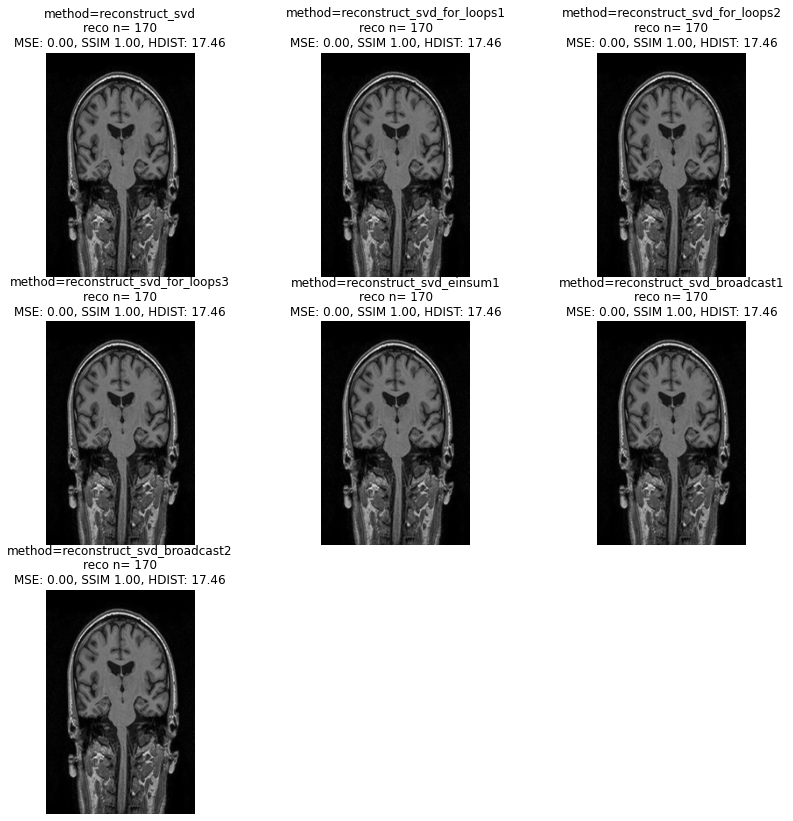

In [15]:
n = 3
fig, axs = plt.subplots(math.ceil(len(methods)/n), n, figsize=(14,14))

for i, r in enumerate(reconstructions):
    axs[i//n, i%n].imshow(reconstructions[r],cmap='gray')
    axs[i//n, i%n].set_title(f"method={r}\nreco n= {k}\n{calculate_metrics(im, reconstructions[r])}")
    
for i in range(math.ceil(len(methods)/n)*n):
    axs[i//n, i%n].set_axis_off()

<font color='blue'>Wir sehen, dass alle Bilder dieselben Werte für die Vergleichsmetriken in der Rekonstruktion erreicht haben. Ein *MSE* von 0, als auch der *SSIM* von 1 bedeutet, dass es keine Abweichungen zwischen der Rekonstruktion und dem Original gibt.</font>

<font color='blue'>In einem nächsten Schritt werden nun noch die Laufzeiten der unterschiedlichen Implementierungen verglichen.</font>

In [16]:
from helper import TimeLogger

In [17]:
k_range = range(im.shape[1], 10, -40)

logger = TimeLogger(u, s, vt)

logger.log_time(method=reconstruct_svd, k_range=k_range, repeat=50, number=100)

logger.log_time(method=reconstruct_svd_for_loops1, k_range=k_range, repeat=20, number=10)

logger.log_time(method=reconstruct_svd_for_loops2, k_range=k_range, repeat=3, number=3)

logger.log_time(method=reconstruct_svd_for_loops3, k_range=k_range, repeat=1, number=1)

logger.log_time(method=reconstruct_svd_einsum1, k_range=k_range, repeat=50, number=50)

logger.log_time(method=reconstruct_svd_broadcast1, k_range=k_range, repeat=20, number=10)

logger.log_time(method=reconstruct_svd_broadcast2, k_range=k_range, repeat=5, number=5)

running with: reconstruct_svd
running with: reconstruct_svd_for_loops1
running with: reconstruct_svd_for_loops2
running with: reconstruct_svd_for_loops3
running with: reconstruct_svd_einsum1
running with: reconstruct_svd_broadcast1
running with: reconstruct_svd_broadcast2


In [18]:
import pandas as pd
import seaborn as sns

log = logger.get_log()
df = pd.DataFrame.from_records(log)
df["mean_per_number"] = df["mean"] / df["number"]
df[df["k"]==170]

,name,k,repeat,number,mean,std,mean_per_number
0,reconstruct_svd,170,50,100,0.024254,0.002992,0.000243
4,reconstruct_svd_for_loops1,170,20,10,0.107151,0.005638,0.010715
8,reconstruct_svd_for_loops2,170,3,3,3.389914,0.035033,1.129971
12,reconstruct_svd_for_loops3,170,1,1,29.968313,0.000000,29.968313
16,reconstruct_svd_einsum1,170,50,50,0.266183,0.006863,0.005324
20,reconstruct_svd_broadcast1,170,20,10,0.094847,0.004302,0.009485
24,reconstruct_svd_broadcast2,170,5,5,3.259539,0.019765,0.651908


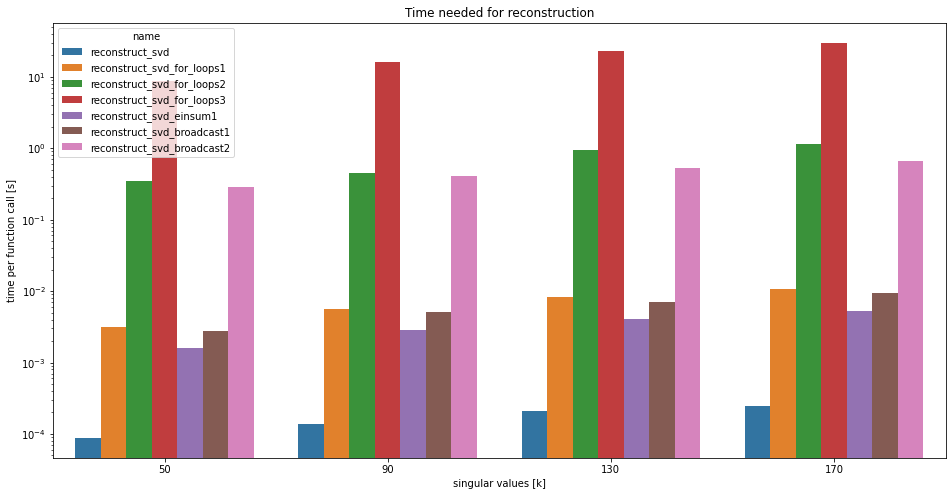

In [19]:
plt.figure(figsize=(16,8))
sns.barplot(data=df, x="k", y="mean_per_number", hue="name").set_yscale("log")
plt.title("Time needed for reconstruction")
plt.xlabel("singular values [k]")
plt.ylabel("time per function call [s]")
plt.show()
### END SOLUTION

#### 2.5 Interpretation der Resultate

Welche der Implementierungen war am schnellsten? Was waren deine Beobachtungen während  der Implementierung? Wo können solche Optimierungen sonst noch eingesetzt werden? Diskutiere in ca. 150-200 Wörtern.

<font color='blue'>Die Visualisierung zeigt die durchschschnittliche Ausführzeit der unterschiedlichen Rekonstruktionsvarianten mit k = 50,90,130, und 170. Von allen untersuchten Methoden ist die Rekonstruktion mit `np.dot` mit Abstand am schnellsten und benötigt weniger als 1 ms für die Rekonstruktion bei k=170. Das liegt daran, dass die numpy Library im Hintergrund auf kompiliertem C-Code läuft.</font>

<font color='blue'>Alle Varianten, welche mit for-loops implementiert wurden sind wie zu erwarten deutlich langsamer. So wird bei k=170 für reconstruct_svd_for_loops1 ca. 10 ms, reconstruct_svd_for_loops1 ca. 1100 ms und reconstruct_svd_for_loops1 ca. 31 s benötigt.</font>

### 3 Parallelisierung mittels Numba

Implementiere nun eine möglichst schnelle Rekonstruktionsvariante des SVDs mittels Numba. Ist es möglich, den Code mit Numba zu beschleunigen? Führe dazu eine Diagnostik aus. Wenn ja, was ist der Speedup-Faktor und welche(r) Teil(e) konnte(n) parallelisiert werden? Falls nein, was sind die Gründe, weshalb es sich nicht parallelisieren lässt? Lassen sich verschachtelte Schleifen parallelisieren? Warum? Diskutiere in ca. 150-200 Wörtern, wann und warum sich Numba für die Parallelisierung eignet - anhand deines Beispiels.

Beachte:
* Beim ersten Mal Ausführen des Codes wird die Zeit des Kompilierens mit eingerechnet.
* Numba eignet sich gut für For-Schleifen

In [20]:
import numba
from numba import jit

### BEGIN SOLUTION

### END SOLUTION
@jit(nopython=True)
def reconstruct_svd_numba(u,s,vt,k):
    """SVD reconstruction for k components using numba
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """

    reco = np.dot(u[...,:k], np.dot(np.diag(s[:k]), vt[:k,...]))
    return reco


@jit(nopython=True)
def reconstruct_svd_for_loops1_numba(u,s,vt,k):
    """SVD reconstruction for k components using 1 for-loop and np.outer()
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    reco = np.zeros((u.shape[0], vt.shape[1]))
    
    for n in range(k):
        reco += np.outer(u[...,n], np.outer(s[n], vt[n,...]))
    return reco


@jit(nopython=True)
def reconstruct_svd_broadcast2_numba(u,s,vt,k):
    """SVD reconstruction for k components using 3 for-loops
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """

    reco = np.zeros((u.shape[0], vt.shape[1]))

    for i in range(u.shape[0]):
        for j in range(vt.shape[1]):
            reco[i][j] = sum(s[:k] * u[i,:k] * vt[:k, j])
    return reco



print("Running 1st initialisation")
reco = reconstruct_svd_numba(u,s,vt,k=170)
reco = reconstruct_svd_for_loops1_numba(u,s,vt,k=170)
reco = reconstruct_svd_broadcast2_numba(u,s,vt,k=170)
print("done")

Running 1st initialisation


C:\Users\samlu\AppData\Local\Temp/ipykernel_8284/3253983782.py:21: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  reco = np.dot(u[...,:k], np.dot(np.diag(s[:k]), vt[:k,...]))


done


In [21]:
logger.log_time(method=reconstruct_svd_numba, k_range=k_range, repeat=50, number=100)
logger.log_time(method=reconstruct_svd_for_loops1_numba, k_range=k_range, repeat=50, number=50)
logger.log_time(method=reconstruct_svd_broadcast2_numba, k_range=k_range, repeat=5, number=5)

running with: reconstruct_svd_numba
running with: reconstruct_svd_for_loops1_numba
running with: reconstruct_svd_broadcast2_numba


In [22]:
numpa_comparison = ["reconstruct_svd", "reconstruct_svd_numba",
                    "reconstruct_svd_for_loops1", "reconstruct_svd_for_loops1_numba",
                    "reconstruct_svd_broadcast2", "reconstruct_svd_broadcast2_numba"]

log = logger.get_log()
df = pd.DataFrame.from_records(log)
df["mean_per_number"] = df["mean"] / df["number"]
df["std_per_number"] = df["std"] / df["number"]
df = df.loc[df["name"].isin(numpa_comparison)].sort_values(["name", "k"])

df["numba"] = df["name"].apply(lambda x: True if x.endswith("_numba") else False)
df["name"] = df["name"].str.replace("_numba", "")

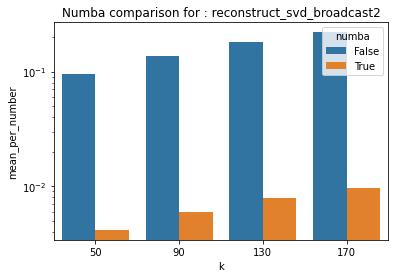

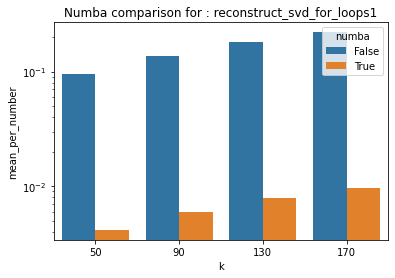

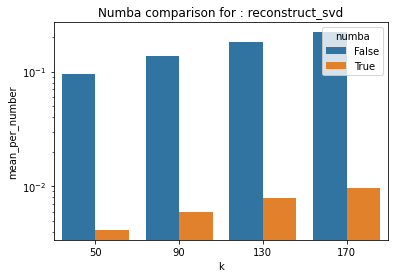

In [23]:
for name in set(df["name"]):
    df_plt = df[df["name"]==name]
    plt.title(f"Numba comparison for : {name}")
    ax = sns.barplot(data=df, x="k", y="mean_per_number", hue="numba", ci=None).set_yscale("log")

    plt.show()

<font color='blue'>Antwort hier eingeben</font>

### 4 Parallelisierung mit Threads

Als nächstes Parallelisieren wir die Rekonstruktion der SVD zerlegten Matrizen mittels unterschiedlichen Thread-Varianten.

Links:
* Threading in Python ([Videokurs](https://realpython.com/courses/threading-python/), [Blogartikel](https://realpython.com/intro-to-python-threading/), [Quiz](https://realpython.com/quizzes/python-threading/)), RealPython
* https://github.com/eth-cscs/PythonHPC/tree/master/intro
* Slides vom Kurs kvanc zum Thema IPC mittels Python

#### 4.1 Einzelne Threads auf einer CPU

Implementiere eine Funktion, welche ein Rekonstruktionsschritt in Thread rekonstruiert. Wähle selbst welchen Schritt du mittels Threading implementierst. Verwende dabei geeignete Lock-Mechanismen. Verwende vor und nach den Lock-Mechanismen geeignete Print/Log-Statements und verwende unterschiedliche Farben der Print-Statements für die Threads. Validiere dein Ergebnis der Rekonstruktion indem du mehrere Threads für einzelne Rekonstruktionsschritte aufruftst.

In [24]:
### BEGIN SOLUTION
import time
import threading



class ReconstructSVDThreading():
    
    def __init__(self, hsplit, wsplit, verbose=False):
        self.colors = ['\033[91m', '\033[92m', '\033[93m', '\033[94m', '\033[95m', '\033[96m', '\033[97m', '\033[98m']
        self.lock = threading.Lock()
        self.hsplit = hsplit
        self.wsplit = wsplit
        self.verbose = verbose
        
    def setup_args(self):
        args = []
        u_ = np.array_split(self.u, self.hsplit, axis=0)
        vt_ = np.array_split(self.vt.T, self.wsplit, axis=1)
        
        u_from, u_to,  = 0, 0
        for h in range(self.hsplit):
            u_to += u_[h].shape[0]
            
            vt_from, vt_to = 0, 0
            for w in range(self.wsplit):
                vt_to += vt_[w].shape[1]
                
                args.append([(u_from, u_to), (vt_from, vt_to), k, h*self.wsplit+w])
                
                vt_from += vt_[w].shape[1]
            u_from += u_[h].shape[0]
        return args

    
    def start_threads(self, u,s,vt,k):
    
        
        self.reco = np.zeros((u.shape[0], vt.shape[1]))
        self.u, self.s, self.vt, self.k = u, s, vt, k

        threads = []
        args = self.setup_args()
        
        for i in range(self.hsplit * self.wsplit):
            t = threading.Thread(target=self.reconstruct_svd_for_loops2, args=args[i])
            t.start()
            threads.append(t)

        for t in threads:
            t.join()

    
    def reconstruct_svd_for_loops2(self, u_idx, vt_idx, k, c):
        for i in range(u_idx[0],u_idx[1]):
            for j in range(vt_idx[0],vt_idx[1]):
                self.reco[i,j] += np.dot(self.u[i,:k].reshape(1,-1), np.dot(np.diag(self.s)[:k, :k], self.vt[:k, j].reshape(-1,1)))
                if self.verbose:
                    print(f"{self.colors[c]}Reconsturct: im[{i}][{j}]")
  
    def get_reconstruction(self):
        return self.reco

    
    
k=170
reconstructor = ReconstructSVDThreading(hsplit=2, wsplit=2)
### END SOLUTION

In [25]:
%timeit reconstructor.start_threads(u,s,vt,k)

2.61 s ± 48.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


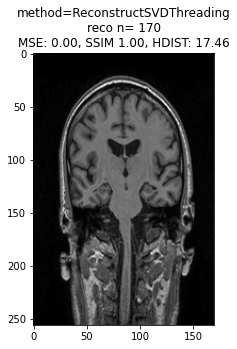

In [26]:
reco = reconstructor.get_reconstruction()
fig, axs = plt.subplots(figsize=(5,5))
plt.imshow(reco, cmap='gray')
axs.set_title(f"method=ReconstructSVDThreading\nreco n= {k}\n{calculate_metrics(im, reco)}")
plt.show()

<font color='blue'>In Python wird der Code standardmässig über ein *Global Interpreter Lock [GIL]*(https://realpython.com/python-gil/) ausgeführt. Dieses stellt sicher, dass jeweils nur ein Thread in Python Zugriff auf den Python Interpreter erhält und ausgeführt wird.</font>

<font color='blue'>Mit der Threading Library ist es möglich, mehrere Threads in Python zu deklarieren. Diese greifen während der Laufzeit abwechslungsweise auf das GIL zu, was eine konkurrente Ausführung der Threads führt.</font>

<font color='blue'>*Lock.quire / Lock.release:*
Greifen mehrere Threads auf dieselbe Ressource konkurrent zu und modifizieren diese, kann das zu Problemen in der Konsistenz der Daten führen. Gibt es Schritte im Code, welche aufeinanderfolgend ausgeführt werden müssen, kann einem bestimmten Thread mittels `threading.Lock`, resp. `Lock.aquire` ein ungeteilter Zugriff auf das GIL garantiert werden. Wird das GIL nicht mehr benötigt, muss es anschliessend mittels `Lock.release` wieder für die anderen Threads freigegeben werden.
In meinem Falle sehe ich keine notwendige Anwendung von Locks, da ich keine synchrone Bearbeitung derselben Daten benötige.</font>

<font color='blue'>Die Rekonstruktion mit k=170 und Multithreading benötigt mehr als zweimal so lange als mit der einfachen Rekonstruktion mit 2 for-loops. Das ist wegen der Initialisierung der einzelnen Threads als auch dem Aufteilen des Bildes geschuldet. Da die Rekonstruktion während der Ausführung auf keine anderen nicht CPU-intensive Inputs warten muss, kann hier durch das Verwenden von Threads keine Laufzeit verringert werden.</font>

#### 4.2 Bonus: Thread-Pool-Executor

Rufe zum Vergleich die unabhängige Rekonstruktionsschritte mittels eines Thread-Pool-Executors auf.

#### 4.3 Bonus: Threads auf mehreren CPUs

Verwende anstelle von Threading Multiprocessing damit die Threads auf mehrere CPUs verteilt werden.

Links:
* Concurrency [Blog](https://realpython.com/python-concurrency/), [Quiz](https://realpython.com/quizzes/python-concurrency/), RealPython


In [27]:
from multiprocessing_class import ReconstructSVDMultiprocessing

k=170
u,s,vt = np.linalg.svd(im, full_matrices=False)
reconstructor = ReconstructSVDMultiprocessing(hsplit=2, wsplit=2)

In [28]:
%timeit reconstructor.start_processes(u,s,vt,k)

1.88 s ± 25.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


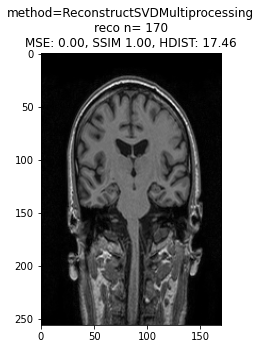

In [29]:
reco = reconstructor.get_reconstruction()
fig, axs = plt.subplots(figsize=(5,5))
plt.imshow(reco, cmap='gray')
axs.set_title(f"method=ReconstructSVDMultiprocessing\nreco n= {k}\n{calculate_metrics(im, reco)}")
plt.show()

<font color='blue'>Die Rekonstruktion mit mehreren Prozessen ist schneller als die Rekonstruktion unter der Verwendung von mehreren Threads. Das liegt daran, dass hier der Rechenaufwand der Rekonstruktion auf mehrere CPU Kerne verteilt wird. Da die Bilder jedoch relativ klein sind, benötigt die Initialisierung der Prozesse mehr Zeit, als durch anschliessende parallele Berechnung gewonnen wird.</font>

#### 4.4 Analyse

1. Macht es in diesem Beispiel Sinn Threads zu benutzen? Wann ist es sinnvoll Threads zu benutzen? Beschreibe in 2-3 Sätzen warum. 

<font color='blue'>In diesem Beispiel ist es nicht sinnvoll, Threads einzusetzen. Das liegt primär am Thread Lock von Python und dass der wesentliche Teil der Laufzeit für die Rekonstruktion dem Rechenaufwand auf der CPU geschuldet ist. Daher kann auch durch die konkurrente Ausführung keine Zeiteinsparung erreicht werden.</font>
    
<font color='blue'>Zudem handelt es sich hier um relativ kleine Bilder, sodass es sich auch nicht wirklich lohnt, die Matrixrekonstruktion (sofern halbwegs intelligent implementiert) mit Multiprocessing zu parallelisieren. In meinem Beispiel habe ich dennoch die ineffiziente Variante mit 2 for-loops verwendet, da ich hier die Differenz in der Laufzeit zwischen Multithreading und Multiprocessing besser aufgezeigten wollte. Der Unterschied war, wegen den kleinen Bildern jedoch weniger stark, als ich das ursprünglich erwartet habe.</font>

2. Könnten in diesem Beispiel auch andere Code-Teile auf mehreren Threads aufgerufen werden? Welche würden sich eignen? Welche nicht? Beschreibe in 2-3 Sätzen warum. 

<font color='blue'>Ich habe in meinem Beispiel einzelne Abschnitte eines Bildes auf mehrere Threads / Prozesse verteilt ausgerechnet. Bei einer anderen Methode, welche wesentlich mehr Rechenaufwand pro Pixel benötigt, könnte es sich eventuell lohnen für jedes Pixel einen einzelnen Prozess zu starten.</font>

<font color='blue'>Bei der Rekonstruktion von mehreren Bildern, wäre es in diesem Beispiel wohl am ehesten noch sinnvoll, die Rekonstruktion ganzer Bilder auf unterschiedliche Prozesse zu verteilen.</font>

3. Was sind die Unterschiede (auch bzgl. Leistung) der manuellen Ausführung des Threadings vs. dem Benutzen eines Thread-Pool-Executors oder von Multiprocessing?

<font color='blue'>
Threading in Python ist geeignet, wenn man mehrere repetitive Tasks abarbeiten möchte, bei denen einen signigikanten Teil ihrer Laufzeit durch das Warten auf andere, nicht CPU lastige Inputs/Outputs verbringen (blocking operations). 
Das Verwenden eines Thread-Pool Executors eignet sich besonders dann, wenn eine repetitive Anzahl an identischen Tasks auf meheren Threads gestartet werden muss. Beim Multiprocessing werden die einzelnen Tasks effektiv auf mehreren CPU Kerne verteilt ausgeführt.</font>

<font color='blue'>
Sowohl beim Threading als auch beim Multiprocessing wird für die Initialisierung der Threads/Prozesse Rechenaufwand und entsprechend Laufzeit benötigt. Es muss also generell abgewogen werden, ob die Verteilung einer Aufgabe, die Initialisierung, als auch die Zusammenführung der Threads/Prozesse kompensieren kann. </font>
